# Semantic Segmentation


1.Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>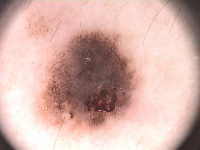</td><td>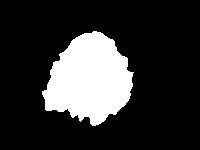</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем сегментировать их.

In [2]:
!nvidia-smi

Sun Jun  7 19:04:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    26W / 250W |      1MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
! wget https://www.dropbox.com/s/4q6kwg8de56eqnc/PH2Dataset.rar

--2020-06-07 19:04:10--  https://www.dropbox.com/s/4q6kwg8de56eqnc/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/4q6kwg8de56eqnc/PH2Dataset.rar [following]
--2020-06-07 19:04:10--  https://www.dropbox.com/s/raw/4q6kwg8de56eqnc/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce5da05595ad91a65bf136f8fbf.dl.dropboxusercontent.com/cd/0/inline/A5MtWBGmEJKY0wFjOt7Fd-sJtUqkyKeIm6TJQMyUkpF2o_q_yOX94QShO-lZaFJDLgVK2yEc3QQjORXRr__aqF6FJNCeHZ3hhu-cRdlYsCTygAUQ2MC-zN660Ykv5i5MnDY/file# [following]
--2020-06-07 19:04:10--  https://uce5da05595ad91a65bf136f8fbf.dl.dropboxusercontent.com/cd/0/inline/A5MtWBGmEJKY0wFjOt7Fd-sJtUqkyKeIm6TJQMyUkpF2o_q_yOX94QShO-lZaFJDLgVK2yEc3QQjORXRr__aqF6FJNCeHZ3hhu-cRdlYs

In [0]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

Для загрузки датасета я предлагаю использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [0]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize) можно использовать для изменения размера изображений. 
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [0]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [7]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [8]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

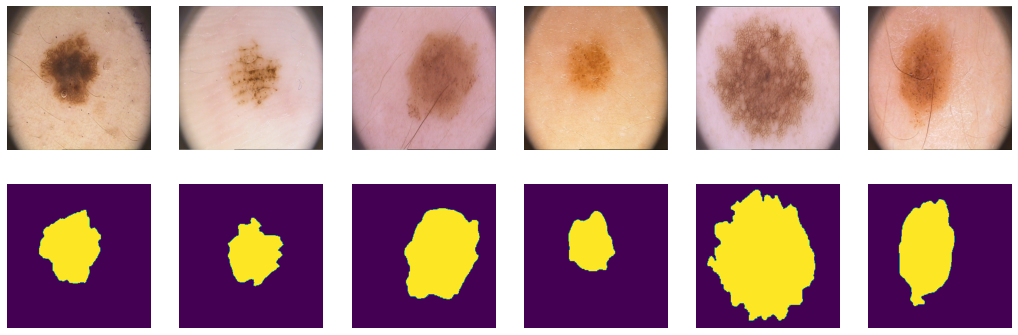

In [9]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для валидации и теста

In [0]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [11]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [0]:
from torch.utils.data import DataLoader
def set_batch_size(batch_size: int):
  data_train = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                      batch_size=batch_size, shuffle=True)
  data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                        batch_size=batch_size, shuffle=True)
  data_test = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
  return data_train, data_val, data_test

In [13]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [0]:
scores_val = []
scores_test = []

# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

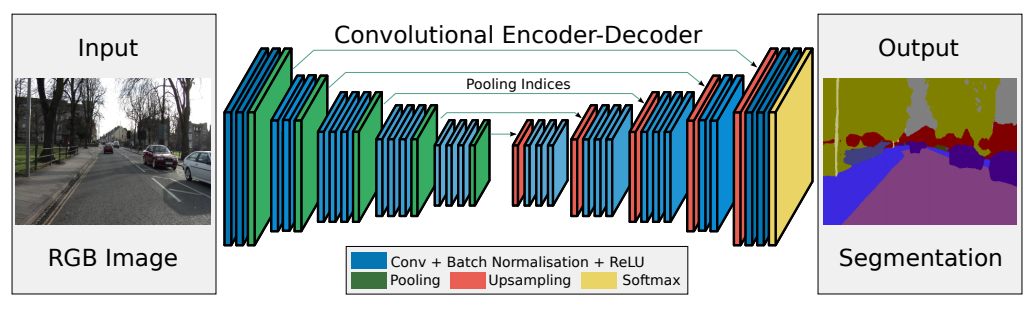

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [0]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)  # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 32 -> 16

        #######################################################################

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        #######################################################################

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2, mode='bilinear') #nn.MaxUnpool2d(2, 2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear') #nn.MaxUnpool2d(kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear') #nn.MaxUnpool2d(kernel_size=2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear') # nn.MaxUnpool2d(kernel_size=2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU(),

            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU()
        )

    def forward(self, x):
        # encoder
        e0 = self.pool0(self.enc_conv0(x))
        e1 = self.pool1(self.enc_conv1(e0))
        e2 = self.pool2(self.enc_conv2(e1))
        e3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(self.upsample0(b))
        d1 = self.dec_conv1(self.upsample1(d0))
        d2 = self.dec_conv2(self.upsample2(d1))
        d3 = self.dec_conv3(self.upsample3(d2))  # no activation

        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


To clarify this we can see on the segmentation:
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


And the intersection will be the following:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [0]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## функция лосса [1 балл]

Теперь не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) в Тарая функция эквивалентна и не так подвержена численной неустойчивости.

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [0]:
def bce_loss(y_real, y_pred, eps = 1e-8):
    return (y_pred-(y_real*y_pred)+torch.log(1+torch.exp(-y_pred)+eps)).mean()

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [0]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, return_loss=False):
    loss_arr = []
    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            
            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            # loss = F.BCELoss(Y_batch, Y_pred)
            # loss = torch.max(loss_fn(Y_pred, Y_batch), 1)
            loss = loss_fn(Y_batch, Y_pred) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)
        loss_arr.append(avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = model(X_val.to(device)).cpu().detach().numpy() # detach and put into cpu

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

    if return_loss:
        return loss_arr

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [0]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [0]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model(X_batch.to(device))
        scores += metric(Y_pred>0, Y_label.to(device)).mean().item()

    return scores/len(data)

## Основной момент: обучение

In [22]:
import gc
gc.collect()

339

In [0]:
data_train, data_val, data_test = set_batch_size(10)

In [0]:
model_SegNet = SegNet().to(device)

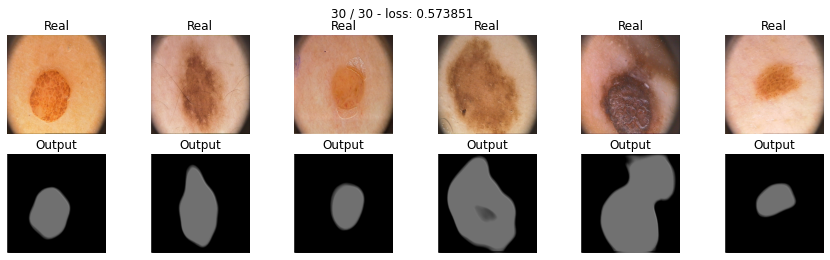

In [25]:
max_epochs = 30
optimizer = optim.Adam(model_SegNet.parameters(), lr=0.0001)
loss_arr_model_SegNet = train(model_SegNet, optimizer, bce_loss, max_epochs, 
                              data_train, data_val, return_loss=True)

In [74]:
scores = score_model(model_SegNet, iou_pytorch, data_val)
print('Validation Score = ' + str(scores))
scores_val.append(scores)

scores = score_model(model_SegNet, iou_pytorch, data_test)
print('Test Score = ' + str(scores))
scores_test.append(scores)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Validation Score = 0.5980000138282776
Test Score = 0.6480000376701355


-----------------------------------------------------------------------------------------

## Дополнительные функции лосса [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

//  Не забудьте подумать о численной нестабильности.


In [0]:
def dice_loss(y_real, y_pred, eps = 1e-8):
    y_pred = torch.sigmoid(y_pred)
    y_pred = y_pred.view(-1)
    y_real = y_real.view(-1)
    
    num = 2*torch.sum(y_real*y_pred)
    den = torch.sum(y_real+y_pred)
    res = (1 - num/(den + eps))
    return res

Проводим тестирование:

In [107]:
gc.collect()

89797

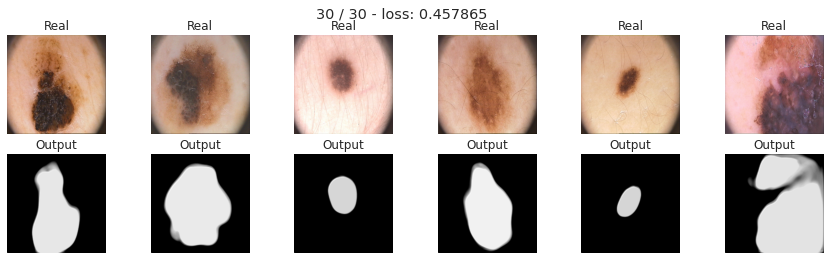

In [108]:
model_dice = SegNet().to(device)

max_epochs = 30
optimaizer = optim.Adam(model_dice.parameters(), lr=0.0001)
loss_arr_model_dice = train(model_dice, optimaizer, dice_loss, max_epochs, 
                            data_train, data_val, return_loss=True)

In [109]:
score = score_model(model_dice, iou_pytorch, data_val)
print('Validation Score = ' + str(scores))
scores_val.append(scores)

scores = score_model(model_dice, iou_pytorch, data_test)
print('Test Score = ' + str(scores))
scores_test.append(scores)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Validation Score = 0.74000004529953
Test Score = 0.7100000262260437


[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [0]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2, alpha=0.8, smooth=1):
        y_pred = F.sigmoid(y_pred)       
        
        y_pred = y_pred.view(-1)
        y_real = y_real.view(-1)
        
        # BCE = F.binary_cross_entropy(y_pred, y_real, reduction='mean')
        bce = bce_loss(y_real, y_pred)
        bce_exp = torch.exp(-bce)
        focal_loss = alpha * (1-bce_exp)**gamma * bce
                       
        return focal_loss

In [32]:
gc.collect()

65083

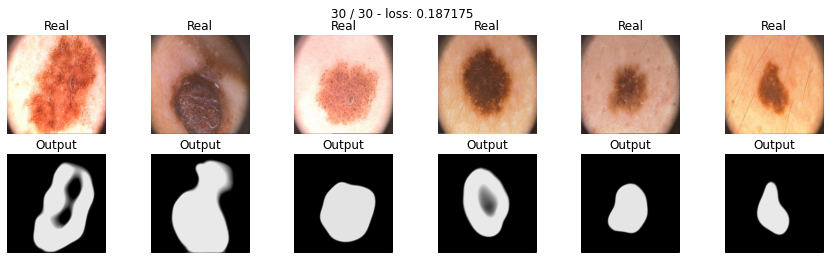

In [33]:
model_focal = SegNet().to(device)

max_epochs = 30
optimaizer = optim.Adam(model_focal.parameters(), lr=0.0001)
loss_arr_model_focal = train(model_focal, optimaizer, focal_loss, max_epochs, data_train, data_val, return_loss=True)

In [76]:
scores = score_model(model_focal, iou_pytorch, data_val)
print('Validation Score = ' + str(scores))
scores_val.append(scores)

scores = score_model(model_focal, iou_pytorch, data_test)
print('Test Score = ' + str(scores))
scores_test.append(scores)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Validation Score = 0.564000028371811
Test Score = 0.5660000503063202


----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаю написать вам 1 функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Tversky loss
5) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

<div style="border-left: solid 6px #d6d6d6; padding: 10px; background-color: #eaeaea">
<b><i>Exercise:</i></b> Add the total variation term to the loss.</div>

In [0]:
def tversky_loss(y_real, y_pred, smooth=1, alpha=0.5, beta=0.5):
        y_pred = F.sigmoid(y_pred)       
        
        y_pred = y_pred.view(-1)
        y_real = y_real.view(-1)
        
        # True Positives, False Positives & False Negatives
        TP = (y_pred * y_real).sum()    
        FP = ((1-y_real) * y_pred).sum()
        FN = (y_real * (1-y_pred)).sum()
       
        tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        
        return 1 - tversky

In [0]:
def tversky_focal_loss(y_real, y_pred, smooth=1, alpha=0.5, beta=0.5, gamma=1):
        y_pred = F.sigmoid(y_pred)       
        
        y_pred = y_pred.view(-1)
        y_real = y_real.view(-1)
        
        # True Positives, False Positives & False Negatives
        TP = torch.sum(y_pred * y_real)   
        FP = torch.sum((1-y_real) * y_pred)
        FN = torch.sum(y_real * (1-y_pred))
       
        tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        focal_tversky = (1 - tversky)**gamma

        return focal_tversky

In [37]:
gc.collect()

65389

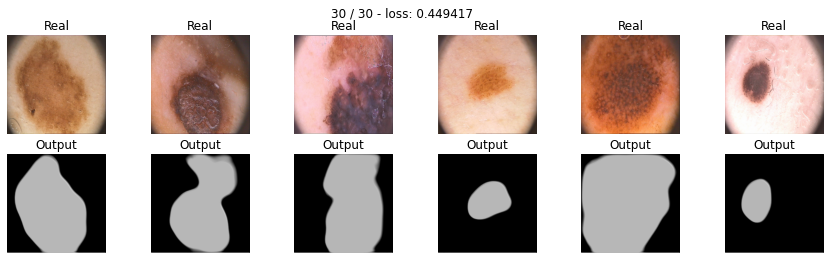

In [38]:
model_tversky = SegNet().to(device)

max_epochs = 30
optimaizer = optim.Adam(model_tversky.parameters(), lr=0.0001)
loss_arr_model_tversky = train(model_tversky, optimaizer, tversky_loss, max_epochs, data_train, data_val, return_loss=True)

In [77]:
scores = score_model(model_tversky, iou_pytorch, data_val)
print('Validation Score = ' + str(scores))
scores_val.append(scores)

scores = score_model(model_tversky, iou_pytorch, data_test)
print('Test Score = ' + str(scores))
scores_test.append(scores)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Validation Score = 0.6740000247955322
Test Score = 0.7099999904632568


In [40]:
gc.collect()

64884

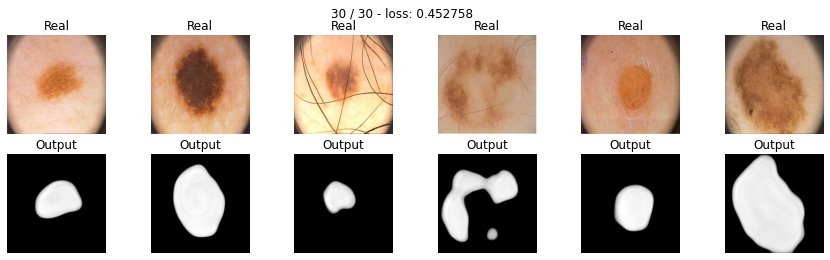

In [41]:
model_tversky_focal = SegNet().to(device)

max_epochs = 30
optimaizer = optim.Adam(model_tversky_focal.parameters(), lr=0.0001)
loss_arr_model_tversky_focal = train(model_tversky_focal, optimaizer, 
                                     tversky_focal_loss, max_epochs, data_train,
                                     data_val, return_loss=True)

In [78]:
scores = score_model(model_tversky_focal, iou_pytorch, data_val)
print('Validation Score = ' + str(scores))
scores_val.append(scores)

scores = score_model(model_tversky_focal, iou_pytorch, data_test)
print('Test Score = ' + str(scores))
scores_test.append(scores)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Validation Score = 0.6680000305175782
Test Score = 0.7360000371932983


-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Учитывая медицинское изображение, он выводит изображение в оттенках серого, представляющее вероятность того, что каждый пиксель является интересующей областью.

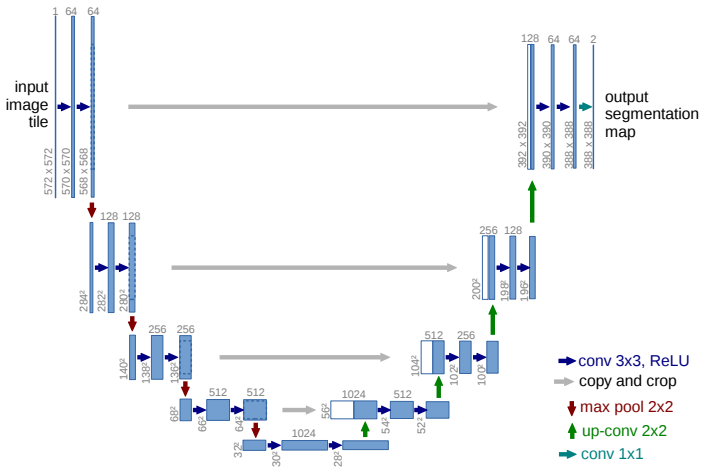

У нас в архитектуре все так же существует енкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются skip-conenctions. Элементы соединяющие части декодера и енкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [0]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)  # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 32 -> 16
        #####################################################################
        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),

            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU()
        )
        #####################################################################

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(1024 , 512, kernel_size=2, stride=2)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.upsample1 = nn.ConvTranspose2d(512 , 256, kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.upsample2 = nn.ConvTranspose2d(256 , 128, kernel_size=2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.upsample3 = nn.ConvTranspose2d(128 , 64, kernel_size=2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU()
        )

    def forward(self, x):
        # encoder
        e0_conv = self.enc_conv0(x)
        e0 = self.pool0(e0_conv)
        
        e1_conv = self.enc_conv1(e0)
        e1 = self.pool1(e1_conv)

        e2_conv = self.enc_conv2(e1)
        e2 = self.pool2(e2_conv)

        e3_conv = self.enc_conv3(e2)
        e3 = self.pool3(e3_conv)

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0_up_cat = torch.cat((self.upsample0(b), e3_conv), 1)
        d0 = self.dec_conv0(d0_up_cat)

        d1_up_cat = torch.cat((self.upsample1(d0), e2_conv), 1)
        d1 = self.dec_conv1(d1_up_cat)

        d2_up_cat = torch.cat((self.upsample2(d1), e1_conv), 1)
        d2 = self.dec_conv2(d2_up_cat)

        d3_up_cat = torch.cat((self.upsample3(d2), e0_conv), 1)
        d3 = self.dec_conv3(d3_up_cat)

        return d3

In [44]:
gc.collect()

64884

In [0]:
unet_model = UNet().to(device)

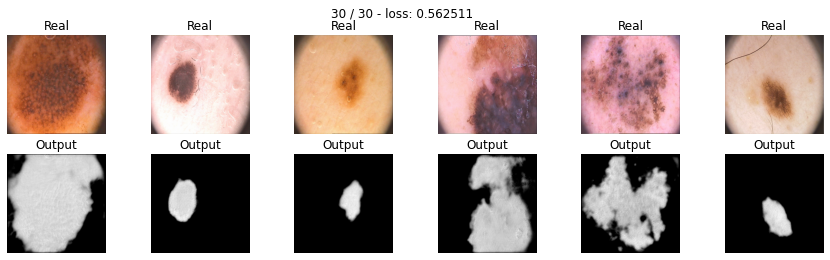

In [46]:
optimizer = optim.Adam(unet_model.parameters(), lr=0.0001)
loss_arr_unet_model = train(unet_model, optimizer, bce_loss, 30, 
                            data_train, data_val, return_loss=True)

In [79]:
scores = score_model(unet_model, iou_pytorch, data_val)
print('Validation Score = ' + str(scores))
scores_val.append(scores)

scores = score_model(unet_model, iou_pytorch, data_test)
print('Test Score = ' + str(scores))
scores_test.append(scores)

Validation Score = 0.6540000319480896
Test Score = 0.7020000338554382


Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [0]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.Conv2d(64 , 64, kernel_size=2, stride=2)

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.Conv2d(128 , 128, kernel_size=2, stride=2) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.Conv2d(256 , 256, kernel_size=2, stride=2) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool3 = nn.Conv2d(512 , 512, kernel_size=2, stride=2) # 32 -> 16
        #####################################################################
        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),

            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU()
        )
        #####################################################################

        # decoder (upsampling)
        # self.upsample0 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True) # 16 -> 32
        self.upsample0 = nn.ConvTranspose2d(1024 , 512, kernel_size=2, stride=2)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.upsample1 = nn.ConvTranspose2d(512 , 256, kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.upsample2 = nn.ConvTranspose2d(256 , 128, kernel_size=2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.upsample3 = nn.ConvTranspose2d(128 , 64, kernel_size=2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU()
        )

    def forward(self, x):
        # encoder
        e0_conv = self.enc_conv0(x)
        e0 = self.pool0(e0_conv)
        e1_conv = self.enc_conv1(e0)
        e1 = self.pool1(e1_conv)
        e2_conv = self.enc_conv2(e1)
        e2 = self.pool2(e2_conv)
        e3_conv = self.enc_conv3(e2)
        e3 = self.pool3(e3_conv)

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0_up_cat = torch.cat((self.upsample0(b), e3_conv), 1)
        d0 = self.dec_conv0(d0_up_cat)

        d1_up_cat = torch.cat((self.upsample1(d0), e2_conv), 1)
        d1 = self.dec_conv1(d1_up_cat)

        d2_up_cat = torch.cat((self.upsample2(d1), e1_conv), 1)
        d2 = self.dec_conv2(d2_up_cat)

        d3_up_cat = torch.cat((self.upsample3(d2), e0_conv), 1)
        d3 = self.dec_conv3(d3_up_cat)

        return d3

In [49]:
gc.collect()

64884

In [0]:
unet2_model = UNet2().to(device)


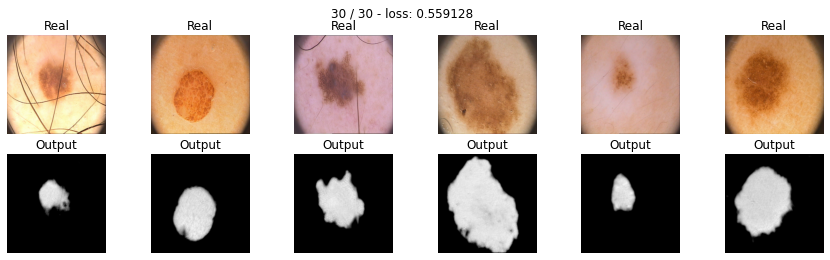

In [51]:
optimizer = optim.Adam(unet2_model.parameters(), lr=0.0001)
loss_arr_unet2_model = train(unet2_model, optimizer, bce_loss, 30, data_train, 
                             data_val, return_loss=True)

In [80]:
scores = score_model(unet2_model, iou_pytorch, data_val)
print('Validation Score = ' + str(scores))
scores_val.append(scores)

scores = score_model(unet2_model, iou_pytorch, data_test)
print('Test Score = ' + str(scores))
scores_test.append(scores)

Validation Score = 0.7180000424385071
Test Score = 0.7320000290870666


Сделайте вывод какая из моделей лучше

# Dilated convolutions [1 балл]



Еще один из вариантов делать upsampling и downsampling - использовать для этого *dilated convolutions*:


* Yu, Fisher, and Vladlen Koltun. "[Multi-scale context aggregation by dilated convolutions.](https://arxiv.org/pdf/1511.07122.pdf)" arXiv preprint arXiv:1511.07122 (2015).

попробуйте написать сеть DilatedUNet, которая использует в одной из предыдущих моделей dilated свертки.

In [0]:
class DilatedSegNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)  # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.BatchNorm2d(512),
            nn.ReLU()

        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 32 -> 16

        #######################################################################

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        #######################################################################

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2, mode='bilinear') #nn.MaxUnpool2d(2, 2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear') #nn.MaxUnpool2d(kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear') #nn.MaxUnpool2d(kernel_size=2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear') # nn.MaxUnpool2d(kernel_size=2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.BatchNorm2d(1),
            nn.ReLU(),

            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.BatchNorm2d(1),
            nn.ReLU()
        )

    def forward(self, x):
        # encoder
        e0 = self.pool0(self.enc_conv0(x))
        e1 = self.pool1(self.enc_conv1(e0))
        e2 = self.pool2(self.enc_conv2(e1))
        e3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(self.upsample0(b))
        d1 = self.dec_conv1(self.upsample1(d0))
        d2 = self.dec_conv2(self.upsample2(d1))
        d3 = self.dec_conv3(self.upsample3(d2))  # no activation

        return d3


In [0]:
class DilatedUNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)  # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 32 -> 16
        #####################################################################
        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),

            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.BatchNorm2d(1024),
            nn.ReLU()
        )
        #####################################################################

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(1024 , 512, kernel_size=2, stride=2)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.upsample1 = nn.ConvTranspose2d(512 , 256, kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.upsample2 = nn.ConvTranspose2d(256 , 128, kernel_size=2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.upsample3 = nn.ConvTranspose2d(128 , 64, kernel_size=2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.BatchNorm2d(1),
            nn.ReLU()
        )

    def forward(self, x):
        # encoder
        e0_conv = self.enc_conv0(x)
        e0 = self.pool0(e0_conv)
        e1_conv = self.enc_conv1(e0)
        e1 = self.pool1(e1_conv)
        e2_conv = self.enc_conv2(e1)
        e2 = self.pool2(e2_conv)
        e3_conv = self.enc_conv3(e2)
        e3 = self.pool3(e3_conv)
        
        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0_up_cat = torch.cat((self.upsample0(b), e3_conv), 1)
        d0 = self.dec_conv0(d0_up_cat)
        d1_up_cat = torch.cat((self.upsample1(d0), e2_conv), 1)
        d1 = self.dec_conv1(d1_up_cat)
        d2_up_cat = torch.cat((self.upsample2(d1), e1_conv), 1)
        d2 = self.dec_conv2(d2_up_cat)
        d3_up_cat = torch.cat((self.upsample3(d2), e0_conv), 1)
        d3 = self.dec_conv3(d3_up_cat)

        return d3  

In [55]:
gc.collect()

64894

In [0]:
dilated_model_SegNet = DilatedSegNet().to(device)

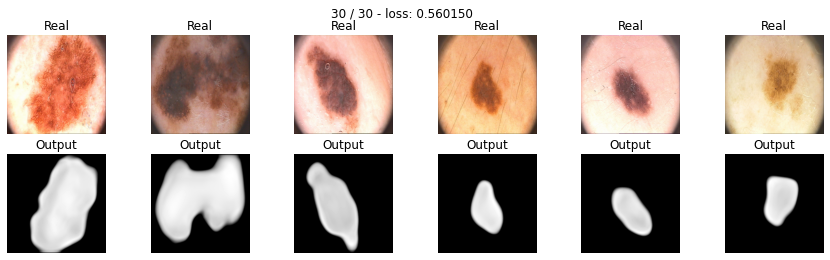

In [57]:
optimizer =optim.Adam(dilated_model_SegNet.parameters(), lr=0.0001)
loss_arr_dilated_model_SegNet = train(model=dilated_model_SegNet, opt=optimizer, 
                                      loss_fn=bce_loss, epochs=30, data_tr=data_train, 
                                      data_val=data_val, return_loss=True)

In [81]:
scores = score_model(dilated_model_SegNet, iou_pytorch, data_val)
print('Validation Score = ' + str(scores))
scores_val.append(scores)

scores = score_model(dilated_model_SegNet, iou_pytorch, data_test)
print('Test Score = ' + str(scores))
scores_test.append(scores)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Validation Score = 0.6860000133514405
Test Score = 0.7379999995231629


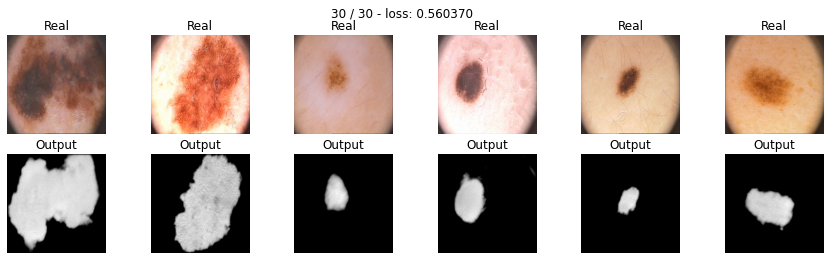

In [59]:
dilated_model_UNet = DilatedUNet().to(device)
optimizer = optim.Adam(dilated_model_UNet.parameters(), lr=0.0001)
loss_arr_dilated_model_UNet = train(model=dilated_model_UNet, opt=optimizer, 
                                    loss_fn=bce_loss, epochs=30, data_tr=data_train, 
                                    data_val=data_val , return_loss=True)

In [82]:
scores = score_model(dilated_model_UNet, iou_pytorch, data_val)
print('Test Score = ' + str(scores))
scores_val.append(scores)

scores = score_model(dilated_model_UNet, iou_pytorch, data_test)
print('Test Score = ' + str(scores))
scores_test.append(scores)

Test Score = 0.6700000166893005
Test Score = 0.7400000095367432


Протестируем также модель UNet с иными Loss функциями


**UNet + Tversky**

In [89]:
gc.collect()

19908

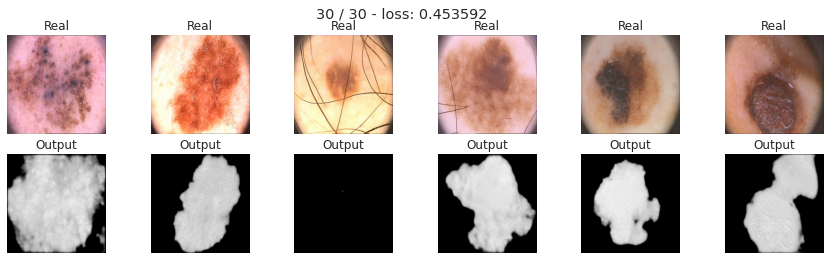

In [91]:
unet_model_tversky = UNet().to(device)
optimizer = optim.Adam(unet_model_tversky.parameters(), lr=0.0001)
loss_arr_unet_model_tversky = train(model=unet_model_tversky, opt=optimizer, 
                                    loss_fn=tversky_loss, epochs=30, data_tr=data_train, 
                                    data_val=data_val , return_loss=True)

In [92]:
scores = score_model(unet_model_tversky, iou_pytorch, data_val)
print('Test Score = ' + str(scores))
scores_val.append(scores)

scores = score_model(unet_model_tversky, iou_pytorch, data_test)
print('Test Score = ' + str(scores))
scores_test.append(scores)

Test Score = 0.6700000286102294
Test Score = 0.7400000333786011


**UNet Dilated + Tversky**

In [93]:
gc.collect()

19282

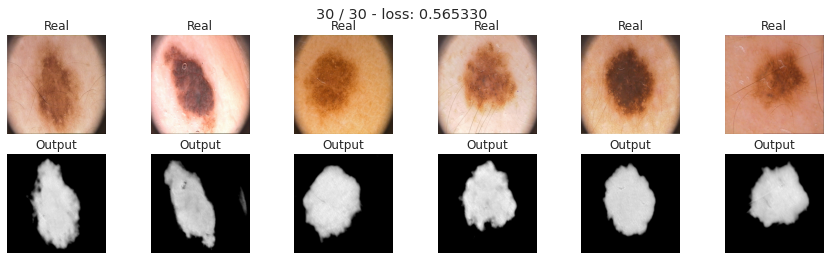

In [94]:
dilated_model_UNet_tversky = DilatedUNet().to(device)
optimizer = optim.Adam(dilated_model_UNet_tversky.parameters(), lr=0.0001)
loss_arr_dilated_model_UNet_tversky = train(model=dilated_model_UNet_tversky, opt=optimizer, 
                                    loss_fn=bce_loss, epochs=30, data_tr=data_train, 
                                    data_val=data_val , return_loss=True)

In [95]:
scores = score_model(dilated_model_UNet, iou_pytorch, data_val)
print('Test Score = ' + str(scores))
scores_val.append(scores)

scores = score_model(dilated_model_UNet, iou_pytorch, data_test)
print('Test Score = ' + str(scores))
scores_test.append(scores)

Test Score = 0.6700000166893005
Test Score = 0.74000004529953


# Отчет (5 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 

Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверябщий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.



In [0]:
x = np.arange(30)
loss_arr = [loss_arr_model_SegNet, loss_arr_model_dice, loss_arr_model_focal, 
            loss_arr_model_tversky,loss_arr_model_tversky_focal, 
            loss_arr_unet_model, loss_arr_unet2_model, 
            loss_arr_dilated_model_SegNet, loss_arr_dilated_model_UNet,
            loss_arr_unet_model_tversky, loss_arr_dilated_model_UNet_tversky
            ]

In [0]:
models = [model_SegNet, model_dice, model_focal, model_tversky,
          model_tversky_focal, unet_model, unet2_model, dilated_model_SegNet, 
          dilated_model_UNet, unet_model_tversky, dilated_model_UNet_tversky]
names = ['SegNet+BCE', 'SegNet+Dice', 'SegNet+Focal', 'SegNet+Tversky', 
         'SegNet+Tversky Focal', 'UNet+BCE', 'UNet_2+BCE', 'dilatedSegNet+BCE',
         'dilatedUNet+BCE','UNet+Tversky', 'dilatedUNet+Tversky']

In [112]:
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

scores_test_checkout = []
scores_val_checkout = []
# _, _, data_test = set_batch_size(8)
for i in tqdm(range(len(names))):
  scores_test_checkout.append(score_model(models[i], iou_pytorch, data_test))
  scores_val_checkout.append(score_model(models[i], iou_pytorch, data_val))

  0%|          | 0/11 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
100%|██████████| 11/11 [00:09<00:00,  1.20it/s]


In [0]:
def plot_loss(loss_arr, names):
    fig, ax = plt.subplots(figsize=(15,10))
    for i in range(len(names)):
        ax.plot(loss_arr[i], label=names[i])
    plt.ylabel('loss')
    plt.xlabel('epochs')

    leg = ax.legend()

In [0]:
def plot_score(scores_test, scores_val, names):
    # Create two subplots and unpack the output array immediately
    f, (ax1, ax2) = plt.subplots(2, figsize=(20,10))
    ax1.bar(names, scores_test, width=0.5)
    ax1.set_title("Score evaluation on test dataset with epochs=30")
    plt.ylabel('score')
   

    ax2.bar(names, scores_val, width=0.5)
    ax2.set_title("Score evaluation on validation dataset with epochs=30")

    plt.ylabel('score')
    plt.show()


В ходе выполнения задания были реализованы и протестированы следующие архитектуры:


*   SegNet + BCE Loss
*   SegNet + Dice Loss
*   SegNet + Focal Loss
*   SegNet + Tversky Loss
*   SegNet + Tversky Focal Loss
*   UNet + BCE Loss
*   UNet_2 + BCE Loss
*   dilatedSegNet + BCE Loss
*   dilatedUNet + BCE Loss
*   UNet + Tversky Loss
*   dilatedUNet + Tversky Loss


*Интерпретируя результаты стоит учесть, что датасет состоит из 200 экземпларов, чего недостаточно для полноценного и объективного анализа.*

*В ходе работы были проведены эксперименты с различными связками архитектур нейронных сетей и loss функций. Ввиду малого размера датасета результаты были нестабильны и часто существенно отличались, что обусловлено начальной инициализацие.*

Для решения этой проблемы были подобраны параметры обучения.


Параметры обучения: 

*   Размер батчей был ограничен 10, чтобы избежать переполнения памяти
*   Количество эпох было выбрано равным 30, что обусловлено экспериментами, которые показали, что повышение их количества не слишком существенно влияет на конечный результат, а понижение приводит к нестабильным результатам
*   В качестве оптимизатора используется Adam с параметром learning rate равным 0.0001, что обеспечивает повышение точности работы модели при сохранении удовлетворительной скорости обучения


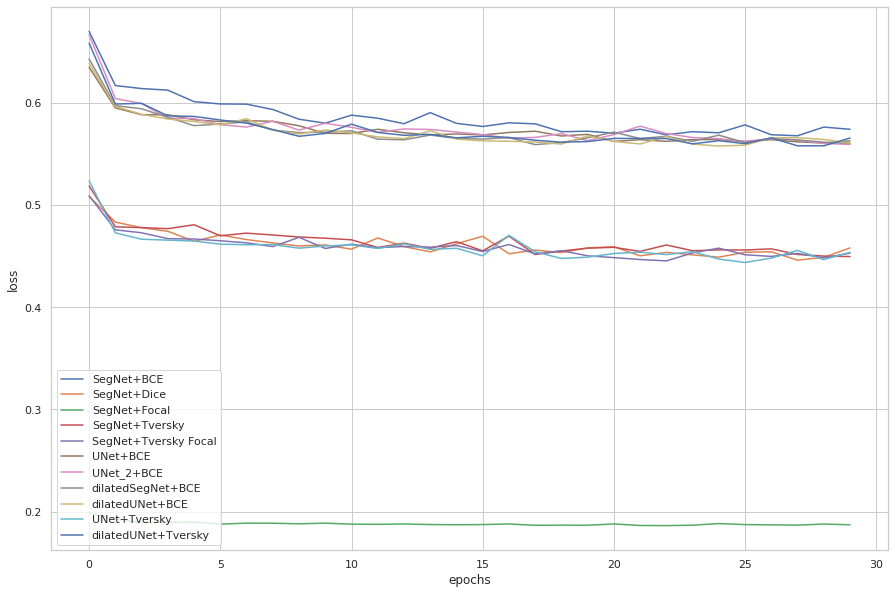

In [123]:
plot_loss(loss_arr, names)

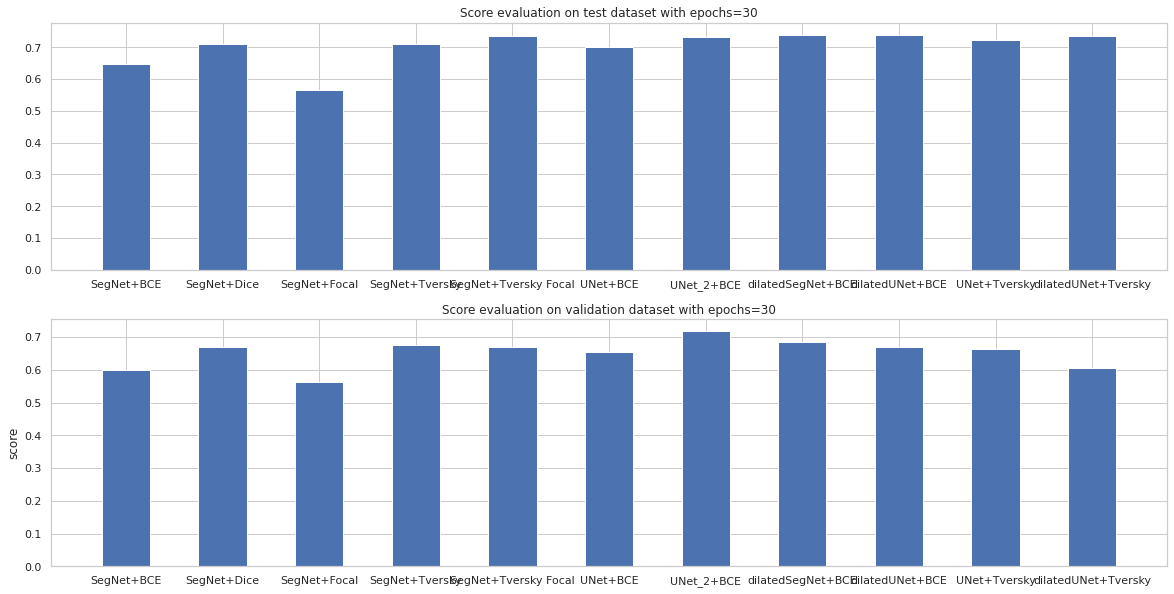

In [124]:
plot_score(scores_test_checkout, scores_val_checkout, names)

Выделим ТОП-3 архитектур 

Для **тестовой** части датасета.

In [125]:
top3_test = sorted(zip(scores_test_checkout, names), reverse=True)[:3]
for i, item in enumerate(top3_test):
    print(str(i+1) + ') ' + str(item[1]) + '\nTest score = ' + str(item[0]))

1) dilatedUNet+BCE
Test score = 0.7400000333786011
2) dilatedSegNet+BCE
Test score = 0.7379999995231629
3) SegNet+Tversky Focal
Test score = 0.7360000371932983


Для **валидационной** части датасета.

In [126]:
top3_val = sorted(zip(scores_val_checkout, names), reverse=True)[:3]
for i, item in enumerate(top3_val):
    print(str(i+1) + ') ' + str(item[1]) + '\nTest score = ' + str(item[0]))

1) UNet_2+BCE
Test score = 0.7180000066757202
2) dilatedSegNet+BCE
Test score = 0.6859999895095825
3) SegNet+Tversky
Test score = 0.6740000247955322


Таким образом, на тестовой выборке наибольшую точность показала связка **Dilated UNet + BCE Loss** при текущем обучении моделей. Несмотря на нестабильность результатов при иных попытках обучения, которые не вошли в финальный вариант, стоит отметить стабильное попадание в ТОП-3 моделей с Dilated свертками и архитектуры UNet. Что касается выбора Loss функции, четкого фаворита выделить не удалось ввиду вышеупомянутой нестабильности. Тем не менее, архитектуры с BCE всегда занимали места в ТОП-3.


Ввиду таких результатов, для сегментации биомедицинских снимков в первую очередь следует пробовать применять модель UNet с различными параметрами.
